Obstacle Avoidance with Dynamic Motion Primitives: This notebook contains examples for the algorithms for adapting DMPs for obstacle avoidance in Python.

get trajectory called...
read successfully..
5.544444561000001
first entry succedded..


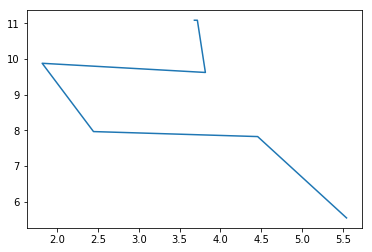

In [14]:
# libraries for loading the recorded trajectory and plotting

import matplotlib.pyplot as plt
from utils import get_trajectory, check_collision, avoid_obstacles

# the trajectory has been recorded in the ROS turtlesim by using the keyboard teleop interface and converted to a csv
# file from a rosbag file.

x, y = get_trajectory("../csv/data.csv")

# Scaling (Done so as to keep the resolution of the grid edge smaller than the distance to consecutive points of 
# the DMP)
# x = [10 * i for i in x]
# y = [10 * j for j in y]

plt.plot(x, y)
plt.show()

For creating a dynamic motion primitive from the demonstrated path

In [15]:
from dmp_discrete import DMPs_discrete
import numpy as np

# specify the number of basis functions in n_bfs, time resolution as dt and total run time.
dmp = DMPs_discrete(n_dmps=2, n_bfs=100, dt=0.01, run_time=1.0)

# learn the weights for the basis functions
dmp.imitate_path(y_des=np.array([x, y]))
print("weights generated for the DMP")

weights generated for the DMP


Specify the start and goal positions for the rollout. In this example, we try to just use the same start and goal positions as in the demonstration.

In [16]:
dmp.y0[0] = x[0]
dmp.y0[1] = y[0]

dmp.goal[0] = x[-1]
dmp.goal[1] = y[-1]

y_track_nc, dy_track_nc, ddy_track_nc, s = dmp.rollout()

In [ ]:
For plotting the rolled out trajectory, execute the cell below.

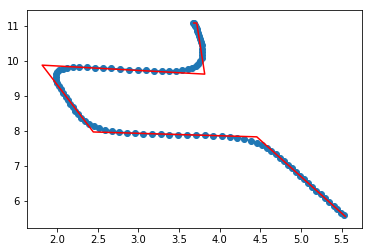

In [17]:
plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])
plt.plot(x, y, color='r')
plt.show()

Insert a obstacle in the world

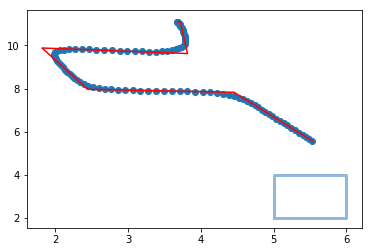

In [20]:
import math
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import Point, mapping
from math import sqrt, ceil, floor

# specify the end points of the polygon.
coords = [(5.0, 2.0), (5.0, 4.0), (6.0, 4.0), (6.0, 2.0)]

obstacle = Polygon(coords)
ob_x, ob_y = obstacle.exterior.xy
plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])
plt.plot(x, y, color='r')
plt.plot(ob_x, ob_y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
